In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Loading the data

In [2]:
df = pd.read_csv("data/hate_speech_data_train.csv")
df

,class,tweet
0,1,RT @__Junebugg: @VoiceOfDStreetz hell yea save...
1,2,How the hell was David Murphy's hit not a home...
2,1,RT @FeeelGreatness: You don't know where your ...
3,1,Thats some hoe shit doe
4,2,I just want vanilla Oreos
...,...,...
19821,1,RT @davegetnmoney: I beat the pussy up up up u...
19822,2,RT @RT_America: Russell Brand mocks Bill O'Rei...
19823,1,@_B_R_Y_C_E_ what happened to going fishing bi...
19824,2,RT @BriannDominguez: Gasoline - daddy Yankee &...


In [3]:
df.columns

Index(['class', 'tweet'], dtype='object')

In [4]:
mask_pickle_file='pickle/mask_pickle'
if os.path.exists(mask_pickle_file):
    file = open(mask_pickle_file,'rb')
    msk = pickle.load(file, encoding='latin1')
else:
    msk = np.random.rand(len(df)) < 0.8
    outfile = open(mask_pickle_file,'wb')
    pickle.dump(msk,outfile)
    outfile.close()

In [5]:
train = df[msk]
test = df[~msk]
print(len(train))
print(len(test))

15853
3973


In [6]:
train["class"].value_counts()

1    12315
2     2618
0      920
Name: class, dtype: int64

In [7]:
test["class"].value_counts()

1    3063
2     678
0     232
Name: class, dtype: int64

In [8]:
df = train

In [9]:
from sklearn.utils import resample

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


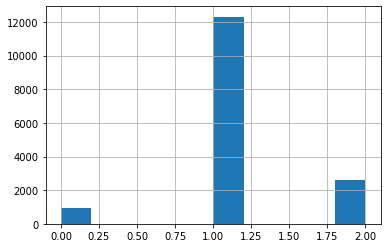

In [10]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [11]:
tweets=df.tweet

## Feature generation

In [12]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yakupgorur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yakupgorur/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [15]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/Users/yakupgorur/opt/anaconda3/envs/alterna/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [16]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [17]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [18]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [19]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [20]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [21]:
feats = get_feature_array(tweets)

In [22]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [23]:
M.shape

(15853, 3639)

In [24]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [47]:
from sklearn.model_selection import KFold 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [34]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [61]:
def forecast_models(X, y, X_test, y_test): 

    clfs = []
    clfs.append(LogisticRegression())
    clfs.append(SVC())
    clfs.append(KNeighborsClassifier(n_neighbors=3))
    clfs.append(DecisionTreeClassifier())
    clfs.append(RandomForestClassifier())
    clfs.append(GradientBoostingClassifier())
    score_dict={}
    for model in clfs:
        model_name = type(model).__name__
        print("---" + type(model).__name__ + " is running" + "---")
        param_grid = [{}] # Optionally add parameters here
        grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5, random_state=42).split(X, y), verbose=2)
        model = grid_search.fit(X, y)
        y_preds = model.predict(X_test)
        report = classification_report( y_test, y_preds )
        score_dict[model_name] = report
    
    return score_dict
        

In [31]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [32]:
X_test = test.tweet
tweet_tags = []
for t in X_test:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)
tfidf = vectorizer.transform(X_test).toarray()
pos = pos_vectorizer.transform(pd.Series(tweet_tags)).toarray()
feats = get_feature_array(X_test)

M = np.concatenate([tfidf,pos,feats],axis=1)
X_test_vectorized = pd.DataFrame(M)
y_test = test['class'].astype(int)


In [62]:
scores = forecast_models(X, y, X_test_vectorized, y_test)

---LogisticRegression is running---
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=  11.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


[CV] ................................................. , total=   9.3s
[CV]  ................................................................
[CV] ................................................. , total=   7.7s
[CV]  ................................................................
[CV] ................................................. , total=  12.9s
[CV]  ................................................................
[CV] ................................................. , total=  10.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.7s finished


---SVC is running---
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total= 9.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.7min remaining:    0.0s


[CV] ................................................. , total= 8.5min
[CV]  ................................................................
[CV] ................................................. , total= 8.3min
[CV]  ................................................................
[CV] ................................................. , total= 8.5min
[CV]  ................................................................
[CV] ................................................. , total= 8.5min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 43.4min finished


---KNeighborsClassifier is running---
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ................................................. , total= 1.2min
[CV]  ................................................................
[CV] ................................................. , total= 1.2min
[CV]  ................................................................
[CV] ................................................. , total= 1.2min
[CV]  ................................................................
[CV] ................................................. , total= 1.2min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.9min finished


---DecisionTreeClassifier is running---
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=  35.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.3s remaining:    0.0s


[CV] ................................................. , total=  31.3s
[CV]  ................................................................
[CV] ................................................. , total=  29.9s
[CV]  ................................................................
[CV] ................................................. , total=  28.9s
[CV]  ................................................................
[CV] ................................................. , total=  29.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished


---RandomForestClassifier is running---
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   2.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] ................................................. , total=   2.7s
[CV]  ................................................................
[CV] ................................................. , total=   2.7s
[CV]  ................................................................
[CV] ................................................. , total=   2.9s
[CV]  ................................................................
[CV] ................................................. , total=   2.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.1s finished


---GradientBoostingClassifier is running---
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=12.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.3min remaining:    0.0s


[CV] ................................................. , total=12.3min
[CV]  ................................................................
[CV] ................................................. , total=12.3min
[CV]  ................................................................
[CV] ................................................. , total=12.4min
[CV]  ................................................................
[CV] ................................................. , total=12.3min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 61.7min finished


In [63]:
for key in scores.keys():
    print("----" + key + " report:" + "----")
    print(scores[key])

----LogisticRegression report:----
              precision    recall  f1-score   support

           0       0.23      0.22      0.23       232
           1       0.88      0.90      0.89      3063
           2       0.67      0.62      0.64       678

    accuracy                           0.81      3973
   macro avg       0.59      0.58      0.59      3973
weighted avg       0.81      0.81      0.81      3973

----SVC report:----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       232
           1       0.82      0.98      0.90      3063
           2       0.77      0.37      0.50       678

    accuracy                           0.82      3973
   macro avg       0.53      0.45      0.46      3973
weighted avg       0.77      0.82      0.78      3973

----KNeighborsClassifier report:----
              precision    recall  f1-score   support

           0       0.19      0.07      0.10       232
           1       0.79      0.97    